## Exploring Cross-architectural Binary Vulnerability Detection

Preliminary goals for this round of experiments:

- Create code that rapidly extracts all fingerprints from a binary
  - Tag them with an ID like [binary_name].[arch].[func_name]
  - Also store function boundary information somewhere?
- Get some statistics on entropy of the dataset
  - What's a good indicator of "how different" each function is from the rest?
- Get some statistics on cross-arch similarity
  - Will probably need to fix whatever's going on with the Arm64 fingerprinting pipeline (see `00_wget_CVE-2019-5953.ipynb`)
  


### Binary-to-fingerprint program
*NOTE*: So I was originally testing this with the wget binary I compiled for x86_64. Turns out I never really added support for x86_64 to the REIL AVM (basically just need to add the register names). So instead I recompiled wget for x86 (32-bit), and in the process, I disabled IRI (because I didn't want to have to track down an x86 version of the dev files for libidn). So don't compare any IDI-related functions.

In [2]:
from elftools.elf.elffile import ELFFile
from elftools.elf.sections import SymbolTableSection, Symbol
from reil.x86.translator import translate
from acevm import REILApproximateVM, REILRegContext, REILMemContext
from multiprocessing import Pool
from os.path import basename
from operator import attrgetter

# Data container class
class FunctionFingerprint:
    def __init__(
        self,
        binary_name,
        function_name,
        address_bounds=[None, None],
        fingerprint=None,
        raw_bytes=None,
    ):
        self.binary_name = binary_name
        self.function_name = function_name
        self.address_bounds = address_bounds
        self.fingerprint = fingerprint
        self.raw_bytes = raw_bytes

    def __repr__(self):
        return "{}: {} [{:x}, {:x}] {}".format(
            self.binary_name,
            self.function_name,
            self.address_bounds[0],
            self.address_bounds[1],
            sum(self.fingerprint),
        )


def get_raw_bytes_f(bin_f, start, stop):
    """
    Get the raw bytes between two MEMORY addresses in an ELF binary
    
    :param bin_f: File object for the binary
    :param start: the starting address to extract
    :param stop: the last address to extract
    :returns: a raw bytes object
    """
    start_addr = list(ELFFile(bin_f).address_offsets(start))[0]
    bin_f.seek(start_addr)
    return bin_f.read(stop - start)


def x86_to_reil(raw_bytes):
    """
    Wrapper function. Returns output from REIL translator in human-readable format
    
    TODO Implement sorting!
    """
    return list(
        il_ins
        for nat_ins in translate(raw_bytes, 0x0, x86_64=False)
        for il_ins in nat_ins.il_instructions
    )


def x86_fingerprint_raw_bytes(raw_bytes):
    avm = REILApproximateVM(REILRegContext.zeros, REILMemContext.address, True)
    reil_code = x86_to_reil(raw_bytes)
    for ins in reil_code:
        avm.execute(ins)
    return avm.t_regs


def x86_complete_fingerprint(inc_fingerprint):
    """
    Thread pool worker. Takes a FunctionFingerprint that has a
    non-None raw_bytes and fills in the corresponding fingerprint.
    Then clears raw bytes.
    """
    inc_fingerprint.fingerprint = x86_fingerprint_raw_bytes(inc_fingerprint.raw_bytes)
    #inc_fingerprint.raw_bytes = None
    return inc_fingerprint


def bin2fingerprints(bin_path, arch="x86_64", threads=6):
    """
    Fingerprints all functions in a binary
    """
    # First we need to get a list of all the functions
    # in the binary (that are worth examining)
    # First, locate the addresses of the functions we want using PyELFtools
    inc_fingerprints = []
    with open(bin_path, "rb") as f:
        # Load the binary's symbol table into PyELFtools
        symtab = ELFFile(f).get_section_by_name(".symtab")
        # Loop over every symbol that we're looking for
        for symbol in symtab.iter_symbols():
            # Only look at function symbols that don't start with __ and are greater than 1 byte
            if (
                symbol["st_info"]["type"] == "STT_FUNC"
                and not symbol.name.startswith("__")
                and int(symbol["st_size"]) > 1
            ):
                name = symbol.name
                start = int(symbol["st_value"])
                end = start + int(symbol["st_size"])
                raw_bytes = get_raw_bytes_f(f, start, end)
                # fp = x86_fingerprint_raw_bytes(raw_bytes)
                # Add incomplete fingerprint to the thread pool queue
                inc_fingerprints.append(
                    FunctionFingerprint(
                        basename(bin_path), name, [start, end], None, raw_bytes
                    )
                )
    with Pool(threads) as pool:
        fingerprints = pool.map(x86_complete_fingerprint, inc_fingerprints)

    return fingerprints

~~Okay, so the above code works, but testing it exposed a bunch of issues with aVM. Essentially we need to stick to 32-bit X86 binaries for right now, and it looks like there's some kind of issue with the ASHR instruction??~~

Thankfully the instruction-specific issues has been resolved after some changes to acevm.py. However, we're still only compatible with 32-bit x86 binaries. Also, **there's still no instruction sorting**!

I also tried to recompile wget for 32-bit, but I'm running into the same DLL-hell that I went through with compiling for ARM. So right now I'm working with the handful of binaries I pulled out of bifrost.

In [3]:

import shelve
PATHS = ["../res/nano", "../res/bc", "../res/dc", "../res/vim", "../res/allcaps"]
with shelve.open('fingerprints.shelve') as fps:
    for path in PATHS:
        fps[path] = bin2fingerprints(path)


/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'translate' raised StopIteration
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: generator 'tra

In [4]:
with shelve.open('fingerprints.shelve') as fps:
    display(fps["../res/nano"])
    display(len(fps["../res/nano"]))
    for app in fps.keys():
        display("{}: {}".format(app, len(fps[app])))
    display(fps["../res/nano"][0].raw_bytes)

[nano: newline_forces_scroll [805f5ec, 805f60f] 262314,
 nano: wrap_to_next_line [805f60f, 805f653] 4294967690,
 nano: set_foreground_color [806093a, 806098b] 10880563805,
 nano: set_background_color [806098b, 80609dc] 10880564925,
 nano: reset_color_pair [8060c67, 8060c94] 10880583174,
 nano: recur_wrefresh [8061497, 80614ca] 17179869773,
 nano: check_mouse_activity [80614ca, 80614dd] 17179869199,
 nano: WipeOut [8061db0, 8061e39] 6442453375,
 nano: _nc_mouse_event [80621a4, 80621ab] 38505,
 nano: _nc_mouse_parse [80621ab, 80624c2] 4294968594,
 nano: init_xterm_mouse [8062647, 8062682] 17179871629,
 nano: _nc_mouse_init [8062682, 806274e] 38506,
 nano: enable_xterm_mouse [806274e, 8062780] 2892,
 nano: mouse_activate [8062780, 8062837] 38505,
 nano: _nc_mouse_inline [80628f0, 8062a6d] -2147478983,
 nano: _nc_mouse_resume [80628a9, 80628ce] -2147478983,
 nano: _nc_mouse_wrap [80628ce, 80628f0] -2147478983,
 nano: normalized_cost [8062cca, 8062d01] 17179878794,
 nano: relative_move [806

923

'../res/vim: 1649'

'../res/allcaps: 6'

'../res/nano: 923'

'../res/bc: 248'

'../res/dc: 229'

b'\x89\xc1Uf\x8b\x02\x89\xe5f;A,|\nf;A.u\x04\xb0\x01\xeb\x06@f\x89\x021\xc0\x0f\xb6\xc0]\xc3'

Seems like Pandas and Hypertools might be useful tools for the job here. Below you'll find some code for getting pandas DataFrames from FunctionFingerprints

In [5]:
import pandas as pd

# Column names of the pandas DF
col_names = ["binary_name", "function_name"] + ['t' + str(x) for x in range(0,32)]

def fingerprints_to_dataframe(function_fingerprints):
    """
    Convert a list of FunctionFingerprint objects into a Pandas DataFrame.
    Note: conversion is lossy
    """
    raw_fp_data = []
    for fp in function_fingerprints:
        fp_dict = {'binary_name': fp.binary_name, 'function_name': fp.function_name}
        for i, cell in enumerate(fp.fingerprint):
            fp_dict['t' + str(i)] = cell
        raw_fp_data.append(fp_dict)
    return pd.DataFrame(raw_fp_data, columns = col_names)

In [6]:
fp_df_list = []
with shelve.open('fingerprints.shelve') as fps:
    for binary in fps.keys():
        fp_df_list.append(fingerprints_to_dataframe(fps[binary]))
fp_df = pd.concat(fp_df_list, ignore_index=True)
del fp_df_list
fp_df

,binary_name,function_name,t0,t1,t2,t3,t4,t5,t6,t7,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
0,vim,find_wininfo,128,128,128,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vim,buf_same_ino,0,76,76,76,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2,vim,chk_modeline,4294967240,4294967240,2147483704,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
3,vim,otherfile_buf,1,0,0,0,38505,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
4,vim,buflist_findname_stat,134983440,-28,2147483660,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,dc,bc_is_zero,1,4,4,-134579984,2282063636,0,2147483648,2147483648,...,0,0,0,0,0,0,0,0,0,0
3051,dc,_load_inttype,0,12,12,12,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
3052,dc,raise,12,-12,2147483660,0,2147483648,2147483648,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
3053,dc,free,0,0,4,4,2406,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I'm going to try to reduce dimensionality of this (so we can eventually plot it). I'm following http://www.apnorton.com/blog/2016/12/19/Visualizing-Multidimensional-Data-in-Python/

In [7]:
# Separate classifications from data
y = fp_df[fp_df.columns[0:2]].apply(
    lambda x: '-'.join(x.dropna().astype(str)),
    axis=1
)
#y = fp_df['binary_name']
X = fp_df.ix[:, 't0':]

# Have to normalize and fill in NaN's with zeroes
X_norm = ((X - X.min())/(X.max() - X.min())).fillna(0)

/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  import sys
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [8]:
X_norm

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
0,0.484765,0.5,0.333333,3.704710e-09,1.238651e-15,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.484765,0.5,0.333333,3.704710e-09,7.409421e-09,0.333333,1.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.969530,1.0,0.666667,7.409420e-09,7.409421e-09,0.666667,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.484765,0.5,0.333333,3.704710e-09,1.340917e-13,0.666667,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.500000,0.5,0.666667,7.409420e-09,7.409421e-09,0.666667,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,0.484765,0.5,0.333333,3.472541e-09,7.873760e-09,0.333333,1.0,1.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3051,0.484765,0.5,0.333333,3.704710e-09,7.409421e-09,0.333333,1.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3052,0.484765,0.5,0.666667,3.704710e-09,7.409421e-09,0.666667,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3053,0.484765,0.5,0.333333,3.704710e-09,9.540025e-15,0.666667,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y

0                vim-find_wininfo
1                vim-buf_same_ino
2                vim-chk_modeline
3               vim-otherfile_buf
4       vim-buflist_findname_stat
                  ...            
3050                dc-bc_is_zero
3051             dc-_load_inttype
3052                     dc-raise
3053                      dc-free
3054               dc-sigprocmask
Length: 3055, dtype: object

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))
transformed

,0,1
0,0.738306,-0.179502
1,0.450427,0.869209
2,-0.684722,-0.098244
3,-0.642740,-0.129968
4,-0.656017,-0.154289
...,...,...
3050,1.066832,0.664016
3051,0.450427,0.869209
3052,-0.603039,0.795141
3053,-0.642740,-0.129968


<IPython.core.display.Javascript object>


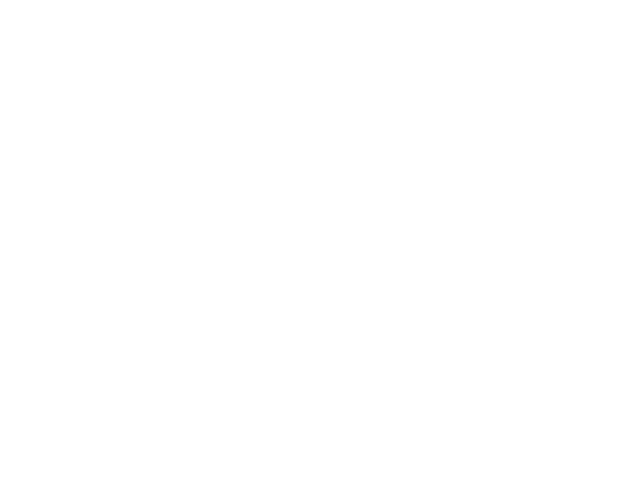

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook
for path in PATHS:
    app = basename(path)
    mask = y.str.contains(app, regex=False)
    plt.scatter(transformed[mask][0], transformed[mask][1], label=app)

plt.legend()
plt.show()

That's interesting... I think. Let's see if anything is more obvious in a 3D plot

In [12]:
pca3d = PCA(n_components=3) #3-dimensional PCA
transformed3d = pd.DataFrame(pca3d.fit_transform(X_norm))
transformed3d

,0,1,2
0,0.738306,-0.179502,-0.219931
1,0.450427,0.869209,-0.073236
2,-0.684722,-0.098244,-0.164005
3,-0.642740,-0.129968,-0.052949
4,-0.656017,-0.154289,0.030920
...,...,...,...
3050,1.066832,0.664016,1.136232
3051,0.450427,0.869209,-0.073236
3052,-0.603039,0.795141,0.278622
3053,-0.642740,-0.129968,-0.052949


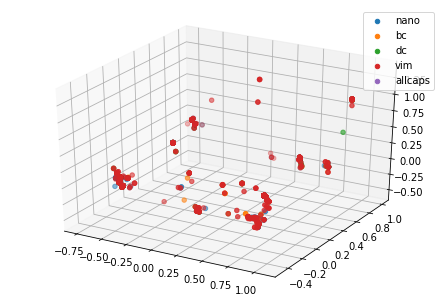

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

for path in PATHS:
    app = basename(path)
    mask = y.str.contains(app, regex=False)
    ax.scatter(transformed3d[mask][0], transformed3d[mask][1], transformed3d[mask][2], label=app)

plt.legend()
plt.show()

Ehhh nothing really much better here. Let's try coloring by function name instead of just apps.

<IPython.core.display.Javascript object>


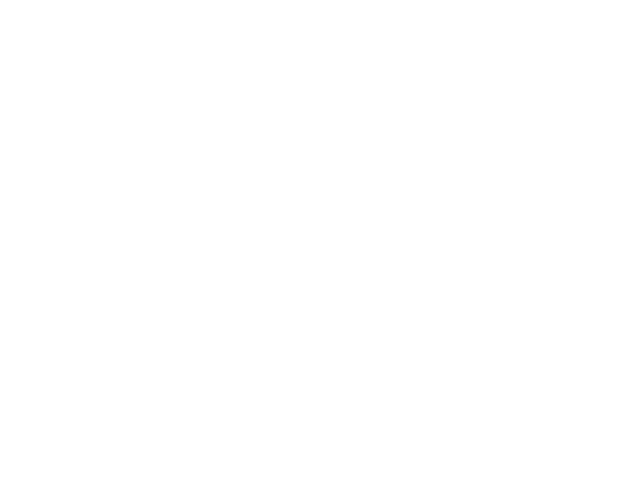

In [14]:
plt.clf()
%matplotlib notebook
leftover_mask = pd.Series(False, index=range(len(y)))
for app in ['printf', 'yy', 'bc_do', 'malloc', 'strcpy', 'memcpy']:
    mask = y.str.contains(app, regex=False)
    plt.scatter(transformed[mask][0], transformed[mask][1], label=app)
    leftover_mask |= mask 

#plt.scatter(transformed[~leftover_mask][0], transformed[~leftover_mask][1], label="else")
plt.legend()
plt.show()

## Stopping Point
What valuable questions can we answer?

I could try to get a couple examples of cross-arch functionality, although that's probably going to lead to a lot of headaches re. getting a cross-compile chain going. I could try to find unstripped ARM binaries online instead, but that still wouldn't solve the issues that aceVM (or pyREIL) is having with ARM code...

*sigh*

**So let's cut cross-arch from the plan.** Conclusion: I was having too many problems cross-compiling and getting my tools (i.e. open source code) to work reliably with other architectures, so I'm going to work on that in the coming months. 

There's still value in testing same-function/different-application. I'll need to find functions that exist in 2 or more of the binaries that I have (this is probably a pandas query). Then I need to test the similarity of thier fingerprints (take cosine distance of raw fingerprints, or euclidian distance of PCA reduction). Hopefully we can find some examples of same function with different fingerprints? (or maybe it's good that we don't find examples of this?)

**You really should** look into how well you can analyze two different versions of the same application/function. To side-step cross-compilation, spin up a 32-bit Ubuntu VM on your laptop/MOC and just compile it there.

**If I have extra time**, I can try to LDA instead of PCA, as suggested in that original tutorial.

Anyways, that's enough musing for now. Let's get started on finding functions that exist in 2 or more binaries

## Finding common functions
Hint: use `pandas.DataFrame.duplicated`

In [15]:
dupe_mask = fp_df.duplicated(subset="function_name", keep=False) # Mark all dupes as True

dupes = fp_df[dupe_mask].sort_values(by='function_name')
dupes

,binary_name,function_name,t0,t1,t2,t3,t4,t5,t6,t7,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
2839,dc,_bc_do_add,1,4294967224,16,4,2147483660,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2590,bc,_bc_do_add,1,4294967224,16,4,2147483660,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2838,dc,_bc_do_compare,0,12,12,12,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2589,bc,_bc_do_compare,0,12,12,12,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2840,dc,_bc_do_sub,1,4294967220,12,4,2147483656,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,vim,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2938,dc,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2072,nano,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2521,nano,wtimeout,0,0,4,4,2406,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Awesome, now let's get the list of unique function names.

In [16]:
common_funcs = dupes.function_name.unique()
len(common_funcs)

327

Now let's test the similarity of those functions across applications. First we'll check how many are just straight duplicates (in terms of fingerprints) of eachother

In [17]:
# Column names of the pandas DF
col_names = ["function_name"] + ['t' + str(x) for x in range(0,32)]
full_dupe_mask = fp_df.duplicated(subset=col_names, keep=False) # Mark all dupes as True
full_dupes = fp_df[full_dupe_mask].sort_values(by='function_name')
full_dupes

,binary_name,function_name,t0,t1,t2,t3,t4,t5,t6,t7,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
2839,dc,_bc_do_add,1,4294967224,16,4,2147483660,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2590,bc,_bc_do_add,1,4294967224,16,4,2147483660,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2838,dc,_bc_do_compare,0,12,12,12,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2589,bc,_bc_do_compare,0,12,12,12,2147483648,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
2840,dc,_bc_do_sub,1,4294967220,12,4,2147483656,0,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,nano,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2938,dc,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
947,vim,write,1,-4294963196,2147479552,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2521,nano,wtimeout,0,0,4,4,2406,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
uniq_full_dupes = full_dupes.function_name.unique()
len(uniq_full_dupes)

267

Awesome, a solid data point! So 267 out of 327 unique functions (81.65%) are *fingerprint-identical* across applications.

**Just a thought,** is this consistent with what Pewny et al. observed? i.e. are ~80% of functions non-identical?

Now let's look into the remaining 60 functions

In [19]:
partial_dupe_mask = full_dupe_mask ^ dupe_mask
partial_dupes = fp_df[partial_dupe_mask].sort_values(by='function_name')
uniq_partial_dupes = partial_dupes.function_name.unique()
display(len(uniq_partial_dupes))
partial_dupes

61

,binary_name,function_name,t0,t1,t2,t3,t4,t5,t6,t7,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
2595,bc,_bc_rec_mul,1,0,0,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
2844,dc,_bc_rec_mul,1,0,0,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,allcaps,_exit,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2502,nano,_nc_baudrate,1,2282269988,0,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,vim,_nc_baudrate,1,2282475348,0,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,nano,typeahead,0,0,143140847,15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2654,bc,usage,4,4,4,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
1875,nano,usage,20,-24,2147483668,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0
2828,dc,usage,4,4,4,2147483648,2147483648,2147483648,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's try plotting the 60 functions (or 61, I guess?) as individual series. We'll use the 2d PCA values.

/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


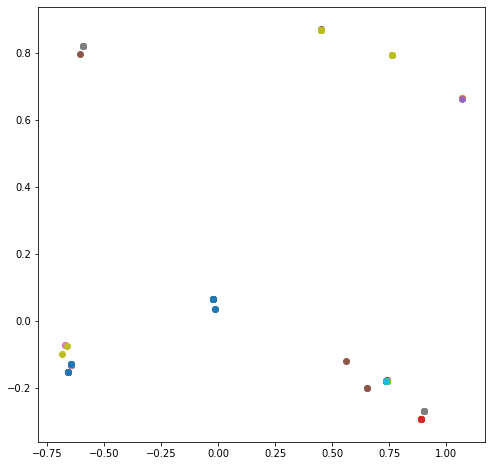

In [20]:
plt.clf()
%matplotlib inline
fig = plt.gcf()
fig.set_size_inches(8, 8)
partial_dupes_pca = transformed[partial_dupe_mask]
for func in uniq_partial_dupes:
    mask = y.str.endswith(func)
    plt.scatter(partial_dupes_pca[mask][0], partial_dupes_pca[mask][1], label=func)

#plt.legend()
plt.show()

Not super helpful... Let's try calculating variance between the fingerprints

/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


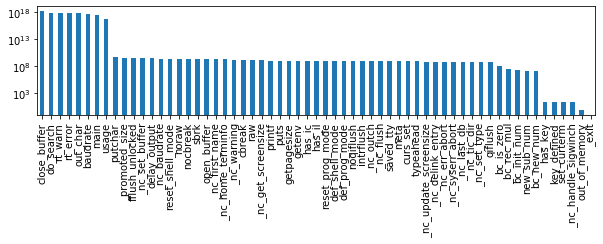

In [24]:
variance = {}
fig = plt.gcf()
fig.set_size_inches(10, 2)
for func in uniq_partial_dupes:
    mask = y.str.endswith(func)
    variance[func] = partial_dupes[mask].ix[:, 't0':].var().mean()
variance = pd.Series(variance).fillna(0).sort_values(ascending=False)
ax = variance.plot.bar(x="Function", y="Mean Variance", log=True)

In [76]:
display(variance.to_csv())

/home/ubuntu/.virtualenvs/ace/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


'close_buffer,1.523106114943465e+18\ndo_search,8.387029263177074e+17\nrt_warn,7.219308260945526e+17\nrt_error,7.219308260945526e+17\nout_char,6.467909891296439e+17\nbaudrate,5.103764029168936e+17\nmain,3.314649335286455e+17\nusage,4.803839638320289e+16\nputchar,5392609863.7109375\n_promoted_size,3378000444.6197915\nfflush_unlocked,3191210123.0078125\n_nc_set_buffer,2706183186.09375\ndelay_output,2706177523.59375\n_nc_baudrate,2047201585.78125\nreset_shell_mode,2046810069.796875\nnoraw,2046756077.53125\nnocbreak,2046756077.53125\nsbrk,1967912494.044271\nopen_buffer,1803560088.5\n_nc_first_name,1798798506.5\n_nc_home_terminfo,1797961881.515625\n_nc_warning,1411258361.09375\ncbreak,1364504051.6875002\nraw,1364504051.6875002\n_nc_get_screensize,1196838352.5\nprintf,1102239868.3333333\nputs,983650390.3776041\ngetpagesize,814974560.3203126\ngetenv,802885510.4947917\nhas_ic,728912269.796875\nhas_il,728912269.796875\nreset_prog_mode,728912269.796875\ndef_shell_mode,728912269.796875\ndef_prog_m

In [96]:
# Column names of the pandas DF
col_names_wrb = ["binary_name", "function_name", "raw_bytes"] + ['t' + str(x) for x in range(0,32)]

def fingerprints_to_dataframe_wrb(function_fingerprints):
    """
    Convert a list of FunctionFingerprint objects into a Pandas DataFrame.
    WITH RAW BYTES
    """
    raw_fp_data = []
    for fp in function_fingerprints:
        fp_dict = {'binary_name': fp.binary_name, 'function_name': fp.function_name, 'raw_bytes': str(fp.raw_bytes)}
        for i, cell in enumerate(fp.fingerprint):
            fp_dict['t' + str(i)] = cell
        raw_fp_data.append(fp_dict)
    return pd.DataFrame(raw_fp_data, columns = col_names_wrb)

fp_df_list = []
with shelve.open('fingerprints.shelve') as fps:
    for binary in fps.keys():
        fp_df_list.append(fingerprints_to_dataframe_wrb(fps[binary]))
fp_df = pd.concat(fp_df_list, ignore_index=True)
del fp_df_list
fp_df

,binary_name,function_name,raw_bytes,t0,t1,t2,t3,t4,t5,t6,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
0,vim,find_wininfo,b'U\x8b\r\x14\xf4\x0b\x08\x8b\x90\x80\x00\x00\...,128,128,128,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vim,buf_same_ino,b'U\x89\xe5VS\x89\xd6\x83xL\x00t)\x8bN\x04\x8b...,0,76,76,76,2147483648,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
2,vim,chk_modeline,"b""U\x89\xe5WVS\x83\xec8\x89\xc6\x89U\xccP\xe8Q...",4294967240,4294967240,2147483704,2147483648,2147483648,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
3,vim,otherfile_buf,b'U\x89\xe5WVS\x83\xecl\x89\xc7\x89\xd6\x89\xc...,1,0,0,0,38505,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
4,vim,buflist_findname_stat,b'U\x89\xe5WVS\x83\xec\x0c\x89\xc7\x89\xd6\x8b...,134983440,-28,2147483660,2147483648,2147483648,2147483648,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,dc,bc_is_zero,b'U\x89\xe5\x83\xec\x14\xa1\x14\x87\x05\x089E\...,1,4,4,-134579984,2282063636,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
3051,dc,_load_inttype,"b'\x8bT$\x04\x8bD$\x08\x83|$\x0c\x00x""\xf6\xc6...",0,12,12,12,2147483648,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
3052,dc,raise,b'\x83\xec\x0c\xe8\xdc\x01\x00\x00RR\xfft$\x18...,12,-12,2147483660,0,2147483648,2147483648,2147483648,...,0,0,0,0,0,0,0,0,0,0
3053,dc,free,b'UWVS\x83\xec\x1c\x8b|$0\x85\xff\x0f\x84\x81\...,0,0,4,4,2406,2147483648,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
col_names = ["function_name", 'raw_bytes'] + ['t' + str(x) for x in range(0,32)]
full_dupe_mask_wrb = fp_df.duplicated(subset=col_names, keep=False) # Mark all dupes as True
full_dupes_wrb = fp_df[full_dupe_mask_wrb].sort_values(by='function_name')
full_dupes_wrb

,binary_name,function_name,raw_bytes,t0,t1,t2,t3,t4,t5,t6,...,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31
2839,dc,_bc_do_add,b'U\x89\xe5\x83\xecH\x8bE\x0c\x8bP\x08\x8bE\x0...,1,4294967224,16,4,2147483660,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
2590,bc,_bc_do_add,b'U\x89\xe5\x83\xecH\x8bE\x0c\x8bP\x08\x8bE\x0...,1,4294967224,16,4,2147483660,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
2838,dc,_bc_do_compare,b'U\x89\xe5\x83\xec \x83}\x10\x00t/\x8bE\x08\x...,0,12,12,12,2147483648,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
2589,bc,_bc_do_compare,b'U\x89\xe5\x83\xec \x83}\x10\x00t/\x8bE\x08\x...,0,12,12,12,2147483648,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
2591,bc,_bc_do_sub,b'U\x89\xe5\x83\xecX\x8bE\x0c\x8bP\x04\x8bE\x0...,1,4294967220,12,4,2147483656,0,2147483648,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,vim,wcsrtombs,"b'\x83\xec\x18\xfft$(\xfft$(j\xff\xfft$,\xfft$...",4,4,4,0,2147483648,2147483648,2147483648,...,0,0,0,0,0,0,0,0,0,0
2717,bc,wcsrtombs,"b'\x83\xec\x18\xfft$(\xfft$(j\xff\xfft$,\xfft$...",4,4,4,0,2147483648,2147483648,2147483648,...,0,0,0,0,0,0,0,0,0,0
2965,dc,wcsrtombs,"b'\x83\xec\x18\xfft$(\xfft$(j\xff\xfft$,\xfft$...",4,4,4,0,2147483648,2147483648,2147483648,...,0,0,0,0,0,0,0,0,0,0
2521,nano,wtimeout,b'U\x89\xe5\x8bU\x08\x85\xd2t\x06\x8bE\x0c\x89...,0,0,4,4,2406,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
uniq_full_dupes_wrb = full_dupes_wrb.function_name.unique()
len(uniq_full_dupes_wrb)

86

Great! So only 86 unique full-duped functions (out of 267) are actually instruction identical! This shows that ACE can see around compiler variations!